In [ ]:
!git clone https://github.com/gagan3012/llm-thought-tracing
%cd llm-thought-tracing
!pip install git+https://github.com/davidbau/baukit datasets bitsandbytes nnsight lime shap --upgrade

Cloning into 'llm-thought-tracing'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 232 (delta 114), reused 134 (delta 54), pack-reused 23 (from 1)
Receiving objects: 100% (232/232), 25.47 MiB | 12.68 MiB/s, done.
Resolving deltas: 100% (114/114), done.
/content/llm-thought-tracing
  Cloning https://github.com/davidbau/baukit to /tmp/pip-req-build-zcqnusox
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit /tmp/pip-req-build-zcqnusox
  Resolved https://github.com/davidbau/baukit to commit 9d51abd51ebf29769aecc38c4cbef459b731a36e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.

In [ ]:
from os import path
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple, Any, Union
from dataclasses import dataclass
from pathlib import Path
import json
import logging
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# LTR imports
from ltr.reasoning_analysis import analyze_reasoning_paths
from ltr.subsequence_analysis import analyze_hallucination_subsequences, SubsequenceAnalyzer
from ltr.logit_lens import logit_lens_analysis, trace_token_evolution
from ltr.patchscopes import perform_patchscope_analysis, analyze_entity_trajectories
from ltr.causal_intervention import perform_causal_intervention
from ltr.concept_extraction import extract_concept_activations
from ltr.behavioral_analysis import analyze_factuality, analyze_prompt_sensitivity
from ltr.attention_analysis import analyze_attention_patterns

# Model imports
from transformers import AutoModelForCausalLM, AutoTokenizer
import lime
from lime.lime_text import LimeTextExplainer
import shap

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


@dataclass
class FaithfulnessResult:
    """Container for faithfulness evaluation results"""
    sample_id: str
    prompt: str
    label: bool
    object_entity: str
    verbalization: str
    counterfactual_verbalization: str

    # Method results
    reasoning_paths: Dict[str, Any]
    subsequence_analysis: Dict[str, Any]
    logit_lens: Dict[str, Any]
    patchscopes: Dict[str, Any]
    ensemble_score: float

    # Baseline results
    lime_score: float
    shap_score: float

    # Aggregate metrics
    faithfulness_score: float
    confidence: float
    interpretability_rank: str


class FaithfulnessEvaluator:
    """
    Comprehensive faithfulness evaluation framework using LTR methods.

    Evaluates model faithfulness through multiple interpretability techniques:
    1. Reasoning path analysis
    2. Subsequence causal analysis
    3. Logit lens visualization
    4. Patchscopes entity tracking
    5. Ensemble method combining all approaches
    6. LIME and SHAP baselines
    """

    def __init__(self,
                 model_name: str = "meta-llama/Llama-3.2-1B-Instruct",
                 device: str = "auto"):
        self.model_name = model_name
        self.device = device
        self.setup_model()
        self.setup_explainers()

    def setup_model(self):
        """Initialize model and tokenizer"""
        logger.info(f"Loading model: {self.model_name}")

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            device_map=self.device,
            torch_dtype=torch.float16,
            trust_remote_code=True
        )

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        logger.info("Model loaded successfully")

    def setup_explainers(self):
        """Initialize LIME and SHAP explainers"""
        try:
            # LIME explainer for text
            self.lime_explainer = LimeTextExplainer(
                class_names=['False', 'True'],
            )

            # SHAP explainer
            self.shap_explainer = shap.Explainer(
                self._predict_proba_for_shap,
                self.tokenizer
            )

            logger.info("Baseline explainers initialized")

        except Exception as e:
            logger.warning(f"Could not initialize baseline explainers: {e}")
            self.lime_explainer = None
            self.shap_explainer = None

    def load_dataset(self, file_path: str, sample_size=20) -> pd.DataFrame:
        """Load and validate the faithfulness dataset"""
        try:
            # if file_path.endswith('.csv'):
            #     df = pd.read_csv(file_path)
            # elif file_path.endswith('.json'):
            #     df = pd.read_json(file_path)
            # else:
            #     raise ValueError("Unsupported file format. Use CSV or JSON.")

            df = pd.read_parquet("hf://datasets/gagan3012/HallData/data/train-00000-of-00001.parquet").sample(n=sample_size, random_state=43)

            # Validate required columns
            required_columns = [
                'prompt', 'label', 'object', 'verbalization', 'counterfactual_verbalization'
            ]

            missing_columns = [col for col in required_columns if col not in df.columns]
            if missing_columns:
                raise ValueError(f"Missing required columns: {missing_columns}")

            # Convert label to boolean
            if df['label'].dtype == 'object':
                df['label'] = df['label'].map({'TRUE': True, 'FALSE': False, True: True, False: False})

            logger.info(f"Loaded dataset with {len(df)} samples")
            logger.info(f"Label distribution: {df['label'].value_counts().to_dict()}")

            return df

        except Exception as e:
            logger.error(f"Error loading dataset: {e}")
            raise

    def evaluate_reasoning_paths(
        self,
        prompt: str,
        object_entity: str,
        verbalization: str,
        counterfactual: str,
        label: bool,
    ) -> Dict[str, Any]:
        try:
            # Define potential reasoning paths
            potential_paths = [
                [object_entity, verbalization, "True"],
                [object_entity, verbalization, "False"],
                [object_entity, counterfactual, "True"],
                [object_entity, counterfactual, "False"],
            ]

            results = analyze_reasoning_paths(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                potential_paths=potential_paths,
                concept_threshold=0.15,
                use_causal_analysis=True,
                use_attention_analysis=True,
            )

            # print(results)

            # Extract all path scores for standardization
            path_scores = results.get("path_scores", [])
            if not path_scores:
                return {"error": "No valid reasoning paths found", "faithfulness_score": 0.5}

            # Standardize path scores
            paths_with_scores = []
            for path_result in path_scores:
                # Parse the result string to extract path, score and components
                path_str = path_result["path"]
                score = path_result["score"]

                # Extract components
                components = path_result.get("score_details", {})
                concept_ordering = components.get("order_score", {})
                activation_strength = components.get("activation_score", {})
                final_confidence = components.get("final_concept_score", 0.0)

                # Extract path elements and expected answer (True/False)
                path_elements = path_str  # Convert string representation to actual list
                expected_answer = path_elements[-1] if path_elements else None

                paths_with_scores.append({
                    "path": path_elements,
                    "raw_score": score,
                    "concept_ordering": concept_ordering,
                    "activation_strength": activation_strength,
                    "final_confidence": final_confidence,
                    "expected_answer": expected_answer,
                    "contains_verbalization": verbalization in path_elements,
                    "contains_counterfactual": counterfactual in path_elements
                })

            # Normalize scores using min-max scaling
            all_scores = [p["raw_score"] for p in paths_with_scores]
            min_score = min(all_scores)
            max_score = max(all_scores)
            score_range = max_score - min_score

            for path_data in paths_with_scores:
                if score_range > 0:
                    path_data["normalized_score"] = (path_data["raw_score"] - min_score) / score_range
                else:
                    path_data["normalized_score"] = 0.5

                # Calculate alignment with ground truth
                label_alignment = 1.0 if path_data["expected_answer"] == label else 0.0

                # Calculate final faithfulness score with components
                if path_data["contains_verbalization"]:
                    verbalization_factor = 1.0
                elif path_data["contains_counterfactual"]:
                    verbalization_factor = 0.5  # Less penalty for counterfactual
                else:
                    verbalization_factor = 0.0

                path_data["faithfulness_score"] = (
                    0.4 * path_data["normalized_score"] +  # Path strength
                    0.4 * label_alignment +                # Alignment with ground truth
                    0.2 * verbalization_factor             # Whether it contains verbalization
                )

            # Sort paths by faithfulness score
            paths_with_scores.sort(key=lambda x: x["faithfulness_score"], reverse=True)
            best_path_data = paths_with_scores[0] if paths_with_scores else None

            # Extract best path for return value
            if best_path_data:
                best_path = best_path_data["path"]
                best_score = best_path_data["raw_score"]
                faithfulness_score = best_path_data["faithfulness_score"]
            else:
                best_path = []
                best_score = 0.0
                faithfulness_score = 0.5

            return {
                "best_path": best_path,
                "best_score": best_score,
                "standardized_paths": paths_with_scores,
                "faithfulness_score": faithfulness_score,
                "all_paths": results.get("path_scores", []),
                "concept_activations": results.get("concept_results", {}),
                "causal_strengths": results.get("causal_strengths", {}),
                "attention_patterns": results.get("attention_patterns", {}),
            }

        except Exception as e:
            logger.error(f"Error in reasoning path analysis: {e}")
            return {"error": str(e), "faithfulness_score": 0.5}

    def evaluate_subsequence_causality(self,
                                    prompt: str,
                                    verbalization: str,
                                    counterfactual: str) -> Dict[str, Any]:
        """Analyze subsequence causality for faithfulness using Srep reproducibility metric"""
        try:
            # Step 1: Run subsequence analysis to identify key subsequences
            verbalization_results = analyze_hallucination_subsequences(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                target_string=verbalization,
                num_perturbations=50,
                perturbation_rate=0.1
            )

            counterfactual_results = analyze_hallucination_subsequences(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                target_string=counterfactual,
                num_perturbations=50,
                perturbation_rate=0.1
            )

            # Step 2: Extract key subsequences from analysis
            verb_subsequences = self._extract_best_subsequences(verbalization_results)
            counter_subsequences = self._extract_best_subsequences(counterfactual_results)

            # Step 3: Compute Srep for each key subsequence (average if multiple)
            srep_scores = []
            counter_srep_scores = []
            original_tokens = self.tokenizer.encode(prompt, add_special_tokens=False)
            analyzer = SubsequenceAnalyzer(self.model, self.tokenizer, device=self.device)
            for subseq in verb_subsequences:
                srep_result = analyzer.compute_srep_reproducibility(
                    subsequence=subseq,
                    original_sequence=original_tokens,
                    target_string=verbalization,
                    num_tests=20
                )
                srep_scores.append(srep_result["srep"])
            for subseq in counter_subsequences:
                srep_result = analyzer.compute_srep_reproducibility(
                    subsequence=subseq,
                    original_sequence=original_tokens,
                    target_string=counterfactual,
                    num_tests=20
                )
                counter_srep_scores.append(srep_result["srep"])
            # Aggregate Srep (mean over top subsequences)
            verb_srep = float(np.mean(srep_scores)) if srep_scores else 0.0
            counter_srep = float(np.mean(counter_srep_scores)) if counter_srep_scores else 0.0

            # Step 4: Calculate faithfulness score based on Srep
            total_srep = verb_srep + counter_srep
            if total_srep > 0:
                faithfulness_score = verb_srep / total_srep
            else:
                faithfulness_score = 0.5

            # Step 5: Get attention analysis for completeness
            attention_analysis = self._analyze_attention_for_causality(
                prompt, verbalization, counterfactual, verb_subsequences, counter_subsequences
            )

            return {
                'verbalization_srep': verb_srep,
                'counterfactual_srep': counter_srep,
                'faithfulness_score': faithfulness_score,
                'verbalization_results': verbalization_results,
                'counterfactual_results': counterfactual_results,
                'attention_analysis': attention_analysis,
                'key_subsequences': {
                    'verbalization': verb_subsequences,
                    'counterfactual': counter_subsequences
                },
                'srep_scores': {
                    'verbalization': srep_scores,
                    'counterfactual': counter_srep_scores
                }
            }
        except Exception as exc:
            logger.error("Error in subsequence Srep analysis: %s", exc)
            import traceback
            traceback.print_exc()
            return {'error': str(exc), 'faithfulness_score': 0.5}

    def _extract_best_subsequences(self, subsequence_results: Dict) -> List[List[int]]:
        """Extract the most promising subsequences from analysis results"""
        subsequence_levels = subsequence_results.get('subsequence_levels', {})
        best_subsequences = []

        # Get top subsequence from each length level
        for length, subsequences in subsequence_levels.items():
            if subsequences and len(subsequences) > 0:
                # Take the best subsequence for this length
                best_subseq, score = subsequences[0]
                if score > 0.1:  # Only include subsequences with meaningful scores
                    best_subsequences.append(best_subseq)

        # Sort by length (longer subsequences are more specific)
        best_subsequences.sort(key=len, reverse=True)
        return best_subsequences[:3]  # Return top 3 subsequences

    def _measure_causal_strength_with_intervention(self,
                                                prompt: str,
                                                target: str,
                                                subsequences: List[List[int]]) -> float:
        """Use causal intervention to measure exact causal strength"""
        if not subsequences:
            # If no subsequences found, use alternative measurement
            return self._measure_baseline_target_probability(prompt, target)

        # Tokenize prompt to get positions
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
        token_ids = inputs.input_ids[0].tolist()

        total_causal_effect = 0.0
        num_interventions = 0

        # Method 1: Try subsequence-based interventions
        for subsequence in subsequences:
            subseq_positions = self._find_subsequence_positions(token_ids, subsequence)

            for start_pos in subseq_positions:
                end_pos = start_pos + len(subsequence)

                try:
                    # Use direct intervention approach
                    intervention_effect = self._direct_intervention_measurement(
                        prompt, target, start_pos, end_pos
                    )

                    if intervention_effect > 0:
                        total_causal_effect += intervention_effect
                        num_interventions += 1

                except Exception as e:
                    logger.warning(f"Direct intervention failed for subsequence at {start_pos}: {e}")
                    continue

        # Method 2: If subsequence interventions fail, try token-level interventions
        if num_interventions == 0:
            logger.info(f"No subsequence interventions worked, trying token-level for target: {target}")
            token_level_effect = self._token_level_intervention_measurement(prompt, target)
            if token_level_effect > 0:
                return token_level_effect

        # Method 3: Fallback to probability-based measurement
        if num_interventions == 0:
            logger.info(f"No interventions worked, using baseline probability for target: {target}")
            return self._measure_baseline_target_probability(prompt, target)

        # Return average causal strength across successful interventions
        return total_causal_effect / num_interventions

    def _direct_intervention_measurement(self,
                                      prompt: str,
                                      target: str,
                                      start_pos: int,
                                      end_pos: int) -> float:
        """Measure causal effect by directly intervening on token positions"""

        # Tokenize prompt
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        original_tokens = inputs.input_ids[0].clone()

        # Get baseline probability for target
        baseline_prob = self._get_target_probability(prompt, target)

        # Create intervention: mask or randomize the subsequence
        modified_tokens = original_tokens.clone()

        # Method 1: Mask tokens with pad token
        if self.tokenizer.pad_token_id is not None:
            modified_tokens[start_pos:end_pos] = self.tokenizer.pad_token_id
        else:
            # Method 2: Replace with random tokens
            vocab_size = self.tokenizer.vocab_size
            for i in range(start_pos, end_pos):
                modified_tokens[i] = torch.randint(0, vocab_size, (1,)).item()

        # Create modified prompt
        modified_prompt = self.tokenizer.decode(modified_tokens, skip_special_tokens=True)

        # Get probability with intervention
        intervention_prob = self._get_target_probability(modified_prompt, target)

        # Calculate intervention effect
        causal_effect = abs(baseline_prob - intervention_prob)

        logger.debug(f"Intervention at {start_pos}-{end_pos}: baseline={baseline_prob:.4f}, "
                    f"intervention={intervention_prob:.4f}, effect={causal_effect:.4f}")

        return causal_effect

    def _token_level_intervention_measurement(self, prompt: str, target: str) -> float:
        """Measure causal effect at individual token level"""

        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        original_tokens = inputs.input_ids[0]

        baseline_prob = self._get_target_probability(prompt, target)

        total_effect = 0.0
        num_tokens = 0

        # Test intervention on each token position
        for pos in range(1, len(original_tokens) - 1):  # Skip special tokens
            try:
                # Create modified sequence with this token masked
                modified_tokens = original_tokens.clone()

                if self.tokenizer.pad_token_id is not None:
                    modified_tokens[pos] = self.tokenizer.pad_token_id
                else:
                    # Use a common token like space or period
                    space_token = self.tokenizer.encode(" ", add_special_tokens=False)
                    if space_token:
                        modified_tokens[pos] = space_token[0]
                    else:
                        continue

                modified_prompt = self.tokenizer.decode(modified_tokens, skip_special_tokens=True)
                intervention_prob = self._get_target_probability(modified_prompt, target)

                effect = abs(baseline_prob - intervention_prob)
                total_effect += effect
                num_tokens += 1

            except Exception as e:
                logger.warning(f"Token intervention failed at position {pos}: {e}")
                continue

        return total_effect / max(num_tokens, 1)

    def _get_target_probability(self, prompt: str, target: str) -> float:
        """Get probability of target appearing in model output"""

        try:
            # Method 1: Generation-based probability
            num_samples = 10
            target_count = 0

            for _ in range(num_samples):
                inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

                with torch.no_grad():
                    outputs = self.model.generate(
                        **inputs,
                        max_new_tokens=50,
                        do_sample=True,
                        temperature=0.7,
                        pad_token_id=self.tokenizer.pad_token_id
                    )

                generated_text = self.tokenizer.decode(
                    outputs[0][inputs.input_ids.shape[1]:],
                    skip_special_tokens=True
                )

                if target.lower() in generated_text.lower():
                    target_count += 1

            generation_prob = target_count / num_samples

            # Method 2: Logit-based probability (for next token prediction)
            logit_prob = self._get_logit_probability(prompt, target)

            # Combine both measurements
            combined_prob = 0.7 * generation_prob + 0.3 * logit_prob

            logger.debug(f"Target '{target}' probability: generation={generation_prob:.4f}, "
                        f"logit={logit_prob:.4f}, combined={combined_prob:.4f}")

            return combined_prob

        except Exception as e:
            logger.error(f"Error getting target probability: {e}")
            return 0.0

    def _get_logit_probability(self, prompt: str, target: str) -> float:
        """Get logit-based probability for target token"""

        try:
            # Encode target to get token ID
            target_tokens = self.tokenizer.encode(target, add_special_tokens=False)
            if not target_tokens:
                return 0.0

            target_token_id = target_tokens[0]  # Use first token

            # Get model logits for the prompt
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

            with torch.no_grad():
                outputs = self.model(**inputs)

            # Get probabilities for the last token position
            last_token_logits = outputs.logits[0, -1]  # [vocab_size]
            probabilities = torch.softmax(last_token_logits, dim=-1)

            # Get probability for target token
            target_prob = probabilities[target_token_id].item()

            return target_prob

        except Exception as e:
            logger.warning(f"Error getting logit probability: {e}")
            return 0.0

    def _measure_baseline_target_probability(self, prompt: str, target: str) -> float:
        """Fallback method to measure target probability without intervention"""

        # Get basic probability of target appearing
        base_prob = self._get_target_probability(prompt, target)

        # Scale it to be meaningful for causal strength
        # This is a heuristic - you might want to adjust based on your domain
        if base_prob > 0.5:
            return 0.8  # High baseline probability suggests strong association
        elif base_prob > 0.2:
            return 0.5  # Medium probability
        elif base_prob > 0.05:
            return 0.3  # Low but meaningful probability
        else:
            return 0.1  # Very low probability

    def _enhanced_subsequence_analysis_with_causality(self,
                                                    prompt: str,
                                                    verbalization: str,
                                                    counterfactual: str) -> Dict[str, Any]:
        """Enhanced analysis combining subsequence analysis with direct causality measurement"""

        # Get subsequence analysis results
        verb_results = analyze_hallucination_subsequences(
            model=self.model,
            tokenizer=self.tokenizer,
            prompt=prompt,
            target_string=verbalization,
            num_perturbations=50,
            perturbation_rate=0.1
        )

        counter_results = analyze_hallucination_subsequences(
            model=self.model,
            tokenizer=self.tokenizer,
            prompt=prompt,
            target_string=counterfactual,
            num_perturbations=50,
            perturbation_rate=0.1
        )

        # Extract baseline probabilities from subsequence analysis
        verb_p_target = verb_results.get('p_target', 0.0)
        counter_p_target = counter_results.get('p_target', 0.0)

        logger.info(f"Subsequence analysis - Verb p_target: {verb_p_target:.4f}, "
                  f"Counter p_target: {counter_p_target:.4f}")

        # If subsequence analysis shows meaningful results, use them
        if verb_p_target > 0.05 or counter_p_target > 0.05:
            # Scale the p_target values to causal strength
            verb_causal = min(verb_p_target * 2, 1.0)  # Scale up but cap at 1.0
            counter_causal = min(counter_p_target * 2, 1.0)
        else:
            # Fallback to direct measurement
            verb_causal = self._measure_baseline_target_probability(prompt, verbalization)
            counter_causal = self._measure_baseline_target_probability(prompt, counterfactual)

        return {
            'verbalization_causal_strength': verb_causal,
            'counterfactual_causal_strength': counter_causal,
            'verb_p_target': verb_p_target,
            'counter_p_target': counter_p_target,
            'measurement_method': 'subsequence_based' if (verb_p_target > 0.05 or counter_p_target > 0.05) else 'baseline'
        }

    # Update the main function to use the enhanced analysis
    def evaluate_subsequence_causality(self,
                                    prompt: str,
                                    verbalization: str,
                                    counterfactual: str) -> Dict[str, Any]:
        """Analyze subsequence causality for faithfulness using enhanced methods"""
        try:
            # Use enhanced analysis that handles zero values
            enhanced_results = self._enhanced_subsequence_analysis_with_causality(
                prompt, verbalization, counterfactual
            )

            verb_causal_strength = enhanced_results['verbalization_causal_strength']
            counter_causal_strength = enhanced_results['counterfactual_causal_strength']

            logger.info(f"Enhanced causal strengths - Verb: {verb_causal_strength:.4f}, "
                      f"Counter: {counter_causal_strength:.4f}")

            # Calculate faithfulness score
            total_strength = verb_causal_strength + counter_causal_strength
            if total_strength > 0:
                faithfulness_score = verb_causal_strength / total_strength
            else:
                faithfulness_score = 0.5

            # Get original subsequence results for completeness
            verbalization_results = analyze_hallucination_subsequences(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                target_string=verbalization,
                num_perturbations=50,
                perturbation_rate=0.1
            )

            counterfactual_results = analyze_hallucination_subsequences(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                target_string=counterfactual,
                num_perturbations=50,
                perturbation_rate=0.1
            )

            # Extract subsequences for attention analysis
            verb_subsequences = self._extract_best_subsequences(verbalization_results)
            counter_subsequences = self._extract_best_subsequences(counterfactual_results)

            # Get attention analysis
            attention_analysis = self._analyze_attention_for_causality(
                prompt, verbalization, counterfactual, verb_subsequences, counter_subsequences
            )

            return {
                'verbalization_causal_strength': verb_causal_strength,
                'counterfactual_causal_strength': counter_causal_strength,
                'faithfulness_score': faithfulness_score,
                'verbalization_results': verbalization_results,
                'counterfactual_results': counterfactual_results,
                'relative_strength_ratio': verb_causal_strength / (counter_causal_strength + 1e-6),
                'raw_verb_p_target': verbalization_results.get('p_target', 0.0),
                'raw_counter_p_target': counterfactual_results.get('p_target', 0.0),
                'attention_analysis': attention_analysis,
                'key_subsequences': {
                    'verbalization': verb_subsequences,
                    'counterfactual': counter_subsequences
                },
                'measurement_method': enhanced_results['measurement_method'],
                'enhanced_analysis': enhanced_results
            }

        except Exception as e:
            logger.error(f"Error in subsequence analysis: {e}")
            import traceback
            traceback.print_exc()
            return {'error': str(e), 'faithfulness_score': 0.5}

    def _analyze_attention_for_causality(self,
                                      prompt: str,
                                      verbalization: str,
                                      counterfactual: str,
                                      verb_subsequences: List[List[int]],
                                      counter_subsequences: List[List[int]]) -> Dict:
        """Analyze attention patterns for causal relationships"""
        try:
            from ltr.attention_analysis import analyze_attention_patterns

            # Get attention patterns for key concepts
            attention_results = analyze_attention_patterns(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                concepts=[verbalization, counterfactual]
            )

            # Tokenize prompt for position analysis
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
            token_ids = inputs.input_ids[0].tolist()
            tokens = self.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

            # Analyze attention focus on key subsequences
            verb_attention_scores = self._calculate_subsequence_attention(
                attention_results, token_ids, verb_subsequences
            )

            counter_attention_scores = self._calculate_subsequence_attention(
                attention_results, token_ids, counter_subsequences
            )

            # Get concept-specific attention patterns
            concept_attention = attention_results.get('concept_attention', {})
            verb_concept_attention = concept_attention.get(verbalization, {})
            counter_concept_attention = concept_attention.get(counterfactual, {})

            return {
                'attention_maps': attention_results.get('attention_maps', {}),
                'head_importance': attention_results.get('head_importance', {}),
                'verbalization_attention_scores': verb_attention_scores,
                'counterfactual_attention_scores': counter_attention_scores,
                'verbalization_concept_attention': verb_concept_attention,
                'counterfactual_concept_attention': counter_concept_attention,
                'attention_focus_ratio': self._calculate_attention_focus_ratio(
                    verb_attention_scores, counter_attention_scores
                )
            }

        except Exception as e:
            logger.error(f"Error in attention analysis: {e}")
            return {'error': str(e)}

    def _find_subsequence_positions(self, sequence: List[int], subsequence: List[int]) -> List[int]:
        """Find all starting positions where subsequence appears in sequence"""
        positions = []
        for i in range(len(sequence) - len(subsequence) + 1):
            if sequence[i:i+len(subsequence)] == subsequence:
                positions.append(i)
        return positions

    def _calculate_subsequence_attention(self,
                                      attention_results: Dict,
                                      token_ids: List[int],
                                      subsequences: List[List[int]]) -> Dict:
        """Calculate attention scores focused on key subsequences"""
        attention_maps = attention_results.get('attention_maps', {})
        subsequence_scores = {}

        for subseq_idx, subsequence in enumerate(subsequences):
            subseq_positions = self._find_subsequence_positions(token_ids, subsequence)

            if not subseq_positions:
                continue

            # Calculate average attention to this subsequence across all heads
            head_scores = {}
            for (layer, head), attention_map in attention_maps.items():
                if attention_map.shape[0] != len(token_ids) or attention_map.shape[1] != len(token_ids):
                    continue

                # Calculate average attention to subsequence positions
                total_attention = 0.0
                for start_pos in subseq_positions:
                    end_pos = start_pos + len(subsequence)
                    # Average attention from all positions to this subsequence
                    subseq_attention = np.mean(attention_map[:, start_pos:end_pos])
                    total_attention += subseq_attention

                head_scores[(layer, head)] = total_attention / len(subseq_positions)

            subsequence_scores[f'subsequence_{subseq_idx}'] = {
                'tokens': subsequence,
                'positions': subseq_positions,
                'head_scores': head_scores,
                'average_attention': np.mean(list(head_scores.values())) if head_scores else 0.0
            }

        return subsequence_scores

    def _calculate_attention_focus_ratio(self,
                                      verb_scores: Dict,
                                      counter_scores: Dict) -> float:
        """Calculate ratio of attention focus between verbalization and counterfactual"""
        verb_avg = np.mean([
            subseq['average_attention'] for subseq in verb_scores.values()
        ]) if verb_scores else 0.0

        counter_avg = np.mean([
            subseq['average_attention'] for subseq in counter_scores.values()
        ]) if counter_scores else 0.0

        total_attention = verb_avg + counter_avg
        if total_attention > 0:
            return verb_avg / total_attention
        else:
            return 0.5

    def _enhanced_causal_intervention_analysis(self,
                                            prompt: str,
                                            verbalization: str,
                                            counterfactual: str) -> Dict:
        """Perform comprehensive causal intervention analysis"""

        # Get all important tokens from prompt
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

        # Perform intervention analysis for both targets
        verb_intervention = perform_causal_intervention(
            model=self.model,
            tokenizer=self.tokenizer,
            prompt=prompt,
            concepts=[verbalization],
            target_positions=list(range(1, len(tokens) - 1)),  # All meaningful positions
            patch_positions=list(range(len(tokens)))
        )

        counter_intervention = perform_causal_intervention(
            model=self.model,
            tokenizer=self.tokenizer,
            prompt=prompt,
            concepts=[counterfactual],
            target_positions=list(range(1, len(tokens) - 1)),
            patch_positions=list(range(len(tokens)))
        )

        # Calculate intervention effects
        verb_effects = self._extract_intervention_effects(verb_intervention, verbalization)
        counter_effects = self._extract_intervention_effects(counter_intervention, counterfactual)

        return {
            'verbalization_intervention': verb_intervention,
            'counterfactual_intervention': counter_intervention,
            'verbalization_effects': verb_effects,
            'counterfactual_effects': counter_effects,
            'effect_ratio': verb_effects['total_effect'] / (counter_effects['total_effect'] + 1e-6)
        }

    def _extract_intervention_effects(self, intervention_result: Dict, target: str) -> Dict:
        """Extract and summarize intervention effects"""
        token_importance = intervention_result.get('token_importance', {}).get(target, [])

        if not token_importance:
            return {'total_effect': 0.0, 'max_effect': 0.0, 'num_important_tokens': 0}

        effects = [abs(item['impact']) for item in token_importance]

        return {
            'total_effect': sum(effects),
            'max_effect': max(effects) if effects else 0.0,
            'avg_effect': np.mean(effects) if effects else 0.0,
            'num_important_tokens': len([e for e in effects if e > 0.01]),  # Threshold for importance
            'top_tokens': sorted(token_importance, key=lambda x: abs(x['impact']), reverse=True)[:5]
        }

    def evaluate_logit_lens(self,
                          prompt: str,
                          verbalization: str,
                          counterfactual: str) -> Dict[str, Any]:
        """Analyze logit lens for faithfulness"""
        try:
            # Get model layers
            n_layers = getattr(self.model.config, 'num_hidden_layers',
                            getattr(self.model.config, 'n_layer', 12))
            target_layers = list(range(0, n_layers, max(1, n_layers // 8)))

            # Tokenize prompt
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
            n_tokens = inputs.input_ids.shape[1]

            # Analyze logit evolution at key positions
            results = logit_lens_analysis(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                target_layers=target_layers,
                target_positions=list(range(max(0, n_tokens-5), n_tokens-1)),  # Focus on last few positions
                top_k=10
            )

            print("Logit lens results:", results)

            # Trace evolution of target concepts
            evolution_results = trace_token_evolution(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                target_tokens=[verbalization, counterfactual],
                start_layer=0
            )

            print("Evolution results:", evolution_results)

            # Extract probability evolution for each target token
            verb_prob_evolution = self._extract_token_probabilities(
                evolution_results, verbalization, target_layers
            )
            counter_prob_evolution = self._extract_token_probabilities(
                evolution_results, counterfactual, target_layers
            )

            print("Verb prob evolution:", verb_prob_evolution)
            print("Counter prob evolution:", counter_prob_evolution)

            # Calculate faithfulness metrics based on probability trajectories
            faithfulness_metrics = self._calculate_logit_lens_faithfulness(
                verb_prob_evolution, counter_prob_evolution, target_layers
            )

            # Analyze prediction consistency across layers
            consistency_analysis = self._analyze_prediction_consistency(
                results, verbalization, counterfactual
            )

            # Calculate final faithfulness score
            faithfulness_score = faithfulness_metrics['relative_strength']

            return {
                'layer_predictions': results.get('layer_results', {}),
                'token_evolution': evolution_results,
                'verbalization_prob_evolution': verb_prob_evolution,
                'counterfactual_prob_evolution': counter_prob_evolution,
                'faithfulness_score': faithfulness_score,
                'faithfulness_metrics': faithfulness_metrics,
                'consistency_analysis': consistency_analysis,
                'final_verbalization_prob': verb_prob_evolution.get('final_avg', 0.0),
                'final_counterfactual_prob': counter_prob_evolution.get('final_avg', 0.0),
                'layer_wise_comparison': self._compare_layer_predictions(
                    verb_prob_evolution, counter_prob_evolution
                )
            }

        except Exception as e:
            logger.error(f"Error in logit lens analysis: {e}")
            import traceback
            traceback.print_exc()
            return {'error': str(e), 'faithfulness_score': 0.5}

    def _extract_token_probabilities(self,
                                  evolution_results: Dict,
                                  target_token: str,
                                  target_layers: List[int]) -> Dict[str, Any]:
        """Extract probability evolution for a target token across layers and positions"""

        token_evolution = evolution_results.get('token_evolution', {})
        target_evolution = token_evolution.get(target_token, {})

        if not target_evolution:
            return {
                'layer_probabilities': {},
                'position_probabilities': {},
                'average_by_layer': {},
                'final_avg': 0.0,
                'trend': 'flat'
            }

        # Extract probabilities by layer and position
        layer_probabilities = {}
        position_probabilities = {}

        for position, layer_data in target_evolution.items():
            position = int(position)
            position_probabilities[position] = {}

            for layer, probability in layer_data.items():
                layer = int(layer)

                if layer not in layer_probabilities:
                    layer_probabilities[layer] = {}

                layer_probabilities[layer][position] = probability
                position_probabilities[position][layer] = probability

        # Calculate average probability by layer
        average_by_layer = {}
        for layer in target_layers:
            if layer in layer_probabilities:
                layer_probs = list(layer_probabilities[layer].values())
                average_by_layer[layer] = np.mean(layer_probs) if layer_probs else 0.0
            else:
                average_by_layer[layer] = 0.0

        # Calculate trend (increasing/decreasing across layers)
        layer_averages = [average_by_layer[layer] for layer in sorted(target_layers)]
        if len(layer_averages) > 1:
            trend_slope = np.polyfit(range(len(layer_averages)), layer_averages, 1)[0]
            if trend_slope > 0.001:
                trend = 'increasing'
            elif trend_slope < -0.001:
                trend = 'decreasing'
            else:
                trend = 'flat'
        else:
            trend = 'flat'

        # Final average across all layers and positions
        all_probs = []
        for layer_data in layer_probabilities.values():
            all_probs.extend(layer_data.values())
        final_avg = np.mean(all_probs) if all_probs else 0.0

        return {
            'layer_probabilities': layer_probabilities,
            'position_probabilities': position_probabilities,
            'average_by_layer': average_by_layer,
            'final_avg': final_avg,
            'trend': trend,
            'max_probability': max(all_probs) if all_probs else 0.0,
            'min_probability': min(all_probs) if all_probs else 0.0
        }

    def _calculate_logit_lens_faithfulness(self,
                                        verb_evolution: Dict,
                                        counter_evolution: Dict,
                                        target_layers: List[int]) -> Dict[str, float]:
        """Calculate faithfulness metrics from logit lens analysis"""

        verb_avg = verb_evolution.get('final_avg', 0.0)
        counter_avg = counter_evolution.get('final_avg', 0.0)

        # Relative strength calculation
        total_prob = verb_avg + counter_avg
        relative_strength = verb_avg / total_prob if total_prob > 0 else 0.5

        # Trend analysis
        verb_trend = verb_evolution.get('trend', 'flat')
        counter_trend = counter_evolution.get('trend', 'flat')

        # Trend score (increasing verbalization trend is good for faithfulness)
        trend_score = 0.5  # Default neutral
        if verb_trend == 'increasing' and counter_trend != 'increasing':
            trend_score = 0.8
        elif verb_trend == 'increasing' and counter_trend == 'increasing':
            trend_score = 0.6
        elif verb_trend != 'decreasing' and counter_trend == 'decreasing':
            trend_score = 0.7
        elif verb_trend == 'decreasing':
            trend_score = 0.3

        # Layer consistency (how stable is the preference across layers)
        verb_layer_avgs = list(verb_evolution.get('average_by_layer', {}).values())
        counter_layer_avgs = list(counter_evolution.get('average_by_layer', {}).values())

        if verb_layer_avgs and counter_layer_avgs:
            verb_consistency = 1.0 - np.std(verb_layer_avgs)  # Lower std = higher consistency
            counter_consistency = 1.0 - np.std(counter_layer_avgs)
            overall_consistency = (verb_consistency + counter_consistency) / 2
        else:
            overall_consistency = 0.5

        # Final faithfulness score combining multiple factors
        faithfulness_score = (
            relative_strength * 0.5 +
            trend_score * 0.3 +
            max(0, overall_consistency) * 0.2
        )

        return {
            'relative_strength': relative_strength,
            'trend_score': trend_score,
            'consistency_score': max(0, overall_consistency),
            'faithfulness_score': max(0, min(1, faithfulness_score)),
            'verb_final_avg': verb_avg,
            'counter_final_avg': counter_avg
        }

    def _analyze_prediction_consistency(self,
                                      logit_results: Dict,
                                      verbalization: str,
                                      counterfactual: str) -> Dict[str, Any]:
        """Analyze how consistently the model predicts verbalization vs counterfactual across layers"""

        layer_results = logit_results.get('layer_results', {})

        consistency_metrics = {
            'verbalization_appearances': 0,
            'counterfactual_appearances': 0,
            'total_predictions': 0,
            'layer_consistency': {},
            'position_consistency': {}
        }

        for layer, layer_data in layer_results.items():
            layer_verb_count = 0
            layer_counter_count = 0
            layer_total = 0

            for position_data in layer_data:
                top_tokens = position_data.get('top_tokens', [])
                layer_total += 1

                # Check if verbalization or counterfactual appear in top predictions
                for token_str, prob in top_tokens:
                    if verbalization.lower() in token_str.lower():
                        layer_verb_count += 1
                        consistency_metrics['verbalization_appearances'] += 1
                    elif counterfactual.lower() in token_str.lower():
                        layer_counter_count += 1
                        consistency_metrics['counterfactual_appearances'] += 1

            if layer_total > 0:
                consistency_metrics['layer_consistency'][layer] = {
                    'verbalization_rate': layer_verb_count / layer_total,
                    'counterfactual_rate': layer_counter_count / layer_total,
                    'preference': 'verbalization' if layer_verb_count > layer_counter_count else 'counterfactual'
                }

            consistency_metrics['total_predictions'] += layer_total

        # Calculate overall consistency
        total_preds = consistency_metrics['total_predictions']
        if total_preds > 0:
            verb_rate = consistency_metrics['verbalization_appearances'] / total_preds
            counter_rate = consistency_metrics['counterfactual_appearances'] / total_preds

            consistency_metrics['overall_verbalization_rate'] = verb_rate
            consistency_metrics['overall_counterfactual_rate'] = counter_rate
            consistency_metrics['preference_strength'] = abs(verb_rate - counter_rate)
            consistency_metrics['dominant_preference'] = 'verbalization' if verb_rate > counter_rate else 'counterfactual'
        else:
            consistency_metrics['overall_verbalization_rate'] = 0.0
            consistency_metrics['overall_counterfactual_rate'] = 0.0
            consistency_metrics['preference_strength'] = 0.0
            consistency_metrics['dominant_preference'] = 'none'

        return consistency_metrics

    def _compare_layer_predictions(self,
                                verb_evolution: Dict,
                                counter_evolution: Dict) -> Dict[str, Any]:
        """Compare how predictions evolve across layers"""

        verb_by_layer = verb_evolution.get('average_by_layer', {})
        counter_by_layer = counter_evolution.get('average_by_layer', {})

        layer_comparison = {}

        # Compare each layer
        for layer in set(list(verb_by_layer.keys()) + list(counter_by_layer.keys())):
            verb_prob = verb_by_layer.get(layer, 0.0)
            counter_prob = counter_by_layer.get(layer, 0.0)

            total = verb_prob + counter_prob
            if total > 0:
                verb_dominance = verb_prob / total
                winner = 'verbalization' if verb_prob > counter_prob else 'counterfactual'
                confidence = abs(verb_prob - counter_prob) / total
            else:
                verb_dominance = 0.5
                winner = 'tie'
                confidence = 0.0

            layer_comparison[layer] = {
                'verbalization_prob': verb_prob,
                'counterfactual_prob': counter_prob,
                'verbalization_dominance': verb_dominance,
                'winner': winner,
                'confidence': confidence
            }

        # Calculate transition points
        layers_sorted = sorted(layer_comparison.keys())
        transitions = []

        for i in range(1, len(layers_sorted)):
            prev_layer = layers_sorted[i-1]
            curr_layer = layers_sorted[i]

            prev_winner = layer_comparison[prev_layer]['winner']
            curr_winner = layer_comparison[curr_layer]['winner']

            if prev_winner != curr_winner:
                transitions.append({
                    'from_layer': prev_layer,
                    'to_layer': curr_layer,
                    'change': f"{prev_winner} -> {curr_winner}"
                })

        return {
            'layer_by_layer': layer_comparison,
            'transitions': transitions,
            'final_winner': layer_comparison.get(max(layers_sorted), {}).get('winner', 'none') if layers_sorted else 'none',
            'num_transitions': len(transitions)
        }

    def evaluate_patchscopes(self,
                           prompt: str,
                           object_entity: str,
                           verbalization: str,
                           counterfactual: str) -> Dict[str, Any]:
        """Analyze patchscopes for faithfulness"""
        try:
            # Get target layers for analysis
            n_layers = getattr(self.model.config, 'num_hidden_layers',
                             getattr(self.model.config, 'n_layer', 12))
            target_layers = list(range(n_layers))

            # Perform patchscope analysis
            results = perform_patchscope_analysis(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                target_entities=[object_entity, verbalization, counterfactual],
                max_tokens=20,
                target_layers=target_layers
            )
            print(results)

            # Analyze entity trajectories
            trajectory_results = analyze_entity_trajectories(
                model=self.model,
                tokenizer=self.tokenizer,
                prompt=prompt,
                entities=[object_entity, verbalization, counterfactual],
                max_tokens=15
            )

            # Calculate faithfulness based on entity consistency
            entity_traces = results.get('entity_traces', {})

            object_trace = entity_traces.get(object_entity, [])
            verb_trace = entity_traces.get(verbalization, [])
            counter_trace = entity_traces.get(counterfactual, [])

            # Calculate average confidence scores
            object_confidence = np.mean([step.get('probability', 0) for step in object_trace]) if object_trace else 0
            verb_confidence = np.mean([step.get('probability', 0) for step in verb_trace]) if verb_trace else 0
            counter_confidence = np.mean([step.get('probability', 0) for step in counter_trace]) if counter_trace else 0

            print(object_confidence, verb_confidence, counter_confidence)

            # Faithfulness score based on relative confidences
            total_confidence = verb_confidence + counter_confidence
            faithfulness_score = verb_confidence / total_confidence if total_confidence > 0 else 0.5

            return {
                'entity_traces': entity_traces,
                'trajectory_results': trajectory_results,
                'object_confidence': object_confidence,
                'verbalization_confidence': verb_confidence,
                'counterfactual_confidence': counter_confidence,
                'faithfulness_score': faithfulness_score,
                'generation_summary': results.get('summary', {})
            }

        except Exception as e:
            logger.error(f"Error in patchscope analysis: {e}")
            return {'error': str(e), 'faithfulness_score': 0.5}

    def evaluate_ensemble_method(self,
                                reasoning_results: Dict,
                                subsequence_results: Dict,
                                logit_results: Dict,
                                patchscope_results: Dict,
                                prompt: str,
                                object_entity: str) -> Dict[str, Any]:
        """Combine all LTR methods for ensemble faithfulness evaluation"""
        try:
            # Extract individual faithfulness scores
            reasoning_score = reasoning_results.get('faithfulness_score', 0.0)
            subsequence_score = subsequence_results.get('faithfulness_score', 0.0)
            logit_score = logit_results.get('faithfulness_score', 0.0)
            patchscope_score = patchscope_results.get('faithfulness_score', 0.0)

            # Weighted ensemble (adjust weights based on method reliability)
            weights = {
                'reasoning': 0.3,    # Reasoning paths are fundamental
                'subsequence': 0.25, # Causal analysis is important
                'logit_lens': 0.2,   # Token evolution shows processing
                'patchscopes': 0.25  # Entity tracking shows consistency
            }
            print("Running ensemble")

            ensemble_score = (
                weights['reasoning'] * reasoning_score +
                weights['subsequence'] * subsequence_score +
                weights['logit_lens'] * logit_score +
                weights['patchscopes'] * patchscope_score
            )

            # Additional ensemble features

            # 1. Cross-method consistency check
            scores = [reasoning_score, subsequence_score, logit_score, patchscope_score]
            consistency = 1.0 - np.std(scores)  # Higher consistency = lower std

            # 2. Confidence estimation
            confidence = np.mean(scores)

            print("confidence", confidence)

            # 3. Multi-layer causal intervention
            try:
                causal_results = perform_causal_intervention(
                    model=self.model,
                    tokenizer=self.tokenizer,
                    prompt=prompt,
                    concepts=[object_entity],
                    target_positions=[5],  # Intervene early in sequence
                    patch_positions=[10],  # Effect on later positions
                )
                causal_strength = causal_results.get('intervention_effects', {}).get('avg_effect', 0.0)
            except:
                causal_strength = 0.0

            print("causal_strength", causal_strength)

            # 4. Attention analysis
            try:
                attention_results = analyze_attention_patterns(
                    model=self.model,
                    tokenizer=self.tokenizer,
                    prompt=prompt,
                    concepts=[object_entity]
                )
                attention_focus = np.mean(list(attention_results.get('concept_attention', {}).get(object_entity, {}).values()))
                if attention_focus is np.nan:
                  attention_focus = 0.0
            except:
                attention_focus = 0.0

            # Adjust ensemble score with additional features
            ensemble_score_adjusted = (
                ensemble_score +
                consistency * 0.1 +
                causal_strength * 0.1 +
                attention_focus * 0.1
            )

            print("consistency", consistency)

            print("causal_strength", causal_strength)

            print("attention_focus", attention_focus)

            print("ensemble_score", ensemble_score)

            print("ensemble_score_adjusted",ensemble_score_adjusted)

            return {
                'ensemble_score': ensemble_score,
                'ensemble_score_adjusted': ensemble_score,
                'individual_scores': {
                    'reasoning': reasoning_score,
                    'subsequence': subsequence_score,
                    'logit_lens': logit_score,
                    'patchscopes': patchscope_score
                },
                'weights': weights,
                'consistency': consistency,
                'confidence': confidence,
                'causal_strength': causal_strength,
                'attention_focus': attention_focus,
                'method_agreement': len([s for s in scores if s > 0.5])  # How many methods agree
            }

        except Exception as e:
            logger.error(f"Error in ensemble method: {e}")
            return {'ensemble_score': 0.5, 'error': str(e)}

    def _predict_proba_for_shap(self, texts):
        """Helper function for SHAP explainer"""
        if isinstance(texts, str):
            texts = [texts]

        probas = []
        for text in texts:
            try:
                inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
                with torch.no_grad():
                    outputs = self.model(**inputs.to(self.model.device))

                # Get probability for True/False classification
                logits = outputs.logits[0, -1]
                probs = torch.softmax(logits, dim=-1)

                # Map to binary classification (simplified)
                yes_tokens = self.tokenizer.encode("Yes", add_special_tokens=False)
                no_tokens = self.tokenizer.encode("No", add_special_tokens=False)

                yes_prob = probs[yes_tokens[0]].item() if yes_tokens else 0.1
                no_prob = probs[no_tokens[0]].item() if no_tokens else 0.1

                total = yes_prob + no_prob
                probas.append([no_prob/total, yes_prob/total])

            except Exception as e:
                probas.append([0.5, 0.5])  # Default neutral prediction

        return np.array(probas)

    def evaluate_baseline_methods(self,
                                prompt: str,
                                label: bool) -> Dict[str, float]:
        """Evaluate LIME and SHAP baselines"""
        results = {'lime_score': 0.0, 'shap_score': 0.0}

        try:
            # LIME analysis
            if self.lime_explainer is not None:
                lime_explanation = self.lime_explainer.explain_instance(
                    prompt,
                    self._predict_proba_for_shap,
                    num_features=10,
                    num_samples=100
                )

                # Extract feature importance for the predicted class
                target_class = 1 if label else 0
                lime_scores = dict(lime_explanation.as_list())
                results['lime_score'] = np.mean([abs(score) for score in lime_scores.values()])

        except Exception as e:
            logger.warning(f"LIME analysis failed: {e}")

        try:
            # SHAP analysis (simplified)
            if self.shap_explainer is not None:
                shap_values = self.shap_explainer([prompt])
                results['shap_score'] = np.mean(np.abs(shap_values.values)) if hasattr(shap_values, 'values') else 0.0

        except Exception as e:
            logger.warning(f"SHAP analysis failed: {e}")

        return results

    def evaluate_sample(self,
                       sample: pd.Series,
                       sample_id: str = None) -> FaithfulnessResult:
        """Evaluate a single sample using all methods"""

        if sample_id is None:
            sample_id = f"sample_{hash(sample['prompt']) % 10000}"

        logger.info(f"Evaluating sample {sample_id}")

        # Extract sample data
        prompt = sample['prompt']
        label = sample['label']
        object_entity = sample['object']
        verbalization = sample['verbalization']
        counterfactual = sample['counterfactual_verbalization']

        # Run all evaluation methods
        logger.debug("Running reasoning path analysis...")
        reasoning_results = self.evaluate_reasoning_paths(
            prompt, object_entity, verbalization, counterfactual, label
        )

        logger.debug("Running subsequence analysis...")
        subsequence_results = self.evaluate_subsequence_causality(
            prompt, verbalization, counterfactual
        )

        logger.debug("Running logit lens analysis...")
        logit_results = self.evaluate_logit_lens(
            prompt, verbalization, counterfactual
        )

        logger.debug("Running patchscope analysis...")
        patchscope_results = self.evaluate_patchscopes(
            prompt, object_entity, verbalization, counterfactual
        )

        logger.debug("Running ensemble method...")
        ensemble_results = self.evaluate_ensemble_method(
            reasoning_results, subsequence_results, logit_results, patchscope_results,
            prompt, object_entity
        )

        logger.debug("Running baseline methods...")
        baseline_results = self.evaluate_baseline_methods(prompt, label)

        # Calculate overall faithfulness score
        ensemble_score = ensemble_results.get('ensemble_score_adjusted',
                                            ensemble_results.get('ensemble_score', 0.5))

        # Calculate confidence based on method agreement
        confidence = ensemble_results.get('confidence', 0.5)

        # Determine interpretability ranking
        if ensemble_score > 0.7 and confidence > 0.6:
            interpretability_rank = "High"
        elif ensemble_score > 0.5 and confidence > 0.4:
            interpretability_rank = "Medium"
        else:
            interpretability_rank = "Low"

        return FaithfulnessResult(
            sample_id=sample_id,
            prompt=prompt,
            label=label,
            object_entity=object_entity,
            verbalization=verbalization,
            counterfactual_verbalization=counterfactual,
            reasoning_paths=reasoning_results,
            subsequence_analysis=subsequence_results,
            logit_lens=logit_results,
            patchscopes=patchscope_results,
            ensemble_score=ensemble_score,
            lime_score=baseline_results['lime_score'],
            shap_score=baseline_results['shap_score'],
            faithfulness_score=ensemble_score,
            confidence=confidence,
            interpretability_rank=interpretability_rank
        )

    def evaluate_dataset(self,
                        df: pd.DataFrame,
                        output_dir: str = "faithfulness_evaluation_results",
                        sample_limit: Optional[int] = None) -> Dict[str, Any]:
        """Evaluate entire dataset"""

        # Create output directory
        Path(output_dir).mkdir(parents=True, exist_ok=True)

        # Limit samples if specified
        if sample_limit is not None:
            df = df.head(sample_limit)
            logger.info(f"Evaluating {len(df)} samples (limited)")
        else:
            logger.info(f"Evaluating {len(df)} samples")

        # Evaluate all samples
        results = []
        for idx, sample in tqdm(df.iterrows(), total=len(df), desc="Evaluating samples"):
            try:
                result = self.evaluate_sample(sample, f"sample_{idx}")
                results.append(result)
            except Exception as e:
                logger.error(f"Error evaluating sample {idx}: {e}")
                continue

        logger.info(f"Successfully evaluated {len(results)} samples")

        # Aggregate results
        aggregate_results = self.aggregate_results(results)

        # Generate visualizations
        self.create_visualizations(results, aggregate_results, output_dir)

        # Save detailed results
        self.save_results(results, aggregate_results, output_dir)

        return {
            'individual_results': results,
            'aggregate_results': aggregate_results,
            'output_dir': output_dir
        }

    def aggregate_results(self, results: List[FaithfulnessResult]) -> Dict[str, Any]:
        """Aggregate results across all samples"""

        if not results:
            return {}

        # Extract metrics
        ensemble_scores = [r.ensemble_score for r in results]
        confidence_scores = [r.confidence for r in results]
        lime_scores = [r.lime_score for r in results]
        shap_scores = [r.shap_score for r in results]

        # Method-specific scores
        reasoning_scores = [r.reasoning_paths.get('faithfulness_score', 0) for r in results]
        subsequence_scores = [r.subsequence_analysis.get('faithfulness_score', 0) for r in results]
        logit_scores = [r.logit_lens.get('faithfulness_score', 0) for r in results]
        patchscope_scores = [r.patchscopes.get('faithfulness_score', 0) for r in results]

        # Calculate correlations with ground truth labels
        labels = [r.label for r in results]

        def safe_correlation(x, y):
            try:
                return np.corrcoef(x, y)[0, 1] if len(set(x)) > 1 and len(set(y)) > 1 else 0.0
            except:
                return 0.0

        return {
            'total_samples': len(results),
            'average_scores': {
                'ensemble': np.mean(ensemble_scores),
                'confidence': np.mean(confidence_scores),
                'reasoning_paths': np.mean(reasoning_scores),
                'subsequence_analysis': np.mean(subsequence_scores),
                'logit_lens': np.mean(logit_scores),
                'patchscopes': np.mean(patchscope_scores),
                'lime': np.mean(lime_scores),
                'shap': np.mean(shap_scores)
            },
            'std_scores': {
                'ensemble': np.std(ensemble_scores),
                'confidence': np.std(confidence_scores),
                'reasoning_paths': np.std(reasoning_scores),
                'subsequence_analysis': np.std(subsequence_scores),
                'logit_lens': np.std(logit_scores),
                'patchscopes': np.std(patchscope_scores),
                'lime': np.std(lime_scores),
                'shap': np.std(shap_scores)
            },
            'correlations_with_labels': {
                'ensemble': safe_correlation(ensemble_scores, labels),
                'reasoning_paths': safe_correlation(reasoning_scores, labels),
                'subsequence_analysis': safe_correlation(subsequence_scores, labels),
                'logit_lens': safe_correlation(logit_scores, labels),
                'patchscopes': safe_correlation(patchscope_scores, labels),
                'lime': safe_correlation(lime_scores, labels),
                'shap': safe_correlation(shap_scores, labels)
            },
            'interpretability_distribution': {
                rank: sum(1 for r in results if r.interpretability_rank == rank)
                for rank in ['High', 'Medium', 'Low']
            },
            'method_agreement': {
                'high_agreement': sum(1 for r in results if r.confidence > 0.7),
                'medium_agreement': sum(1 for r in results if 0.4 <= r.confidence <= 0.7),
                'low_agreement': sum(1 for r in results if r.confidence < 0.4)
            }
        }

    def create_visualizations(self,
                            results: List[FaithfulnessResult],
                            aggregate_results: Dict[str, Any],
                            output_dir: str):
        """Create comprehensive visualizations"""

        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")

        # Figure 1: Method comparison
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Average scores by method
        methods = ['ensemble', 'reasoning_paths', 'subsequence_analysis', 'logit_lens', 'patchscopes', 'lime', 'shap']
        avg_scores = [aggregate_results['average_scores'][method] for method in methods]
        std_scores = [aggregate_results['std_scores'][method] for method in methods]

        results_df = pd.DataFrame({
            'Method': methods,
            'Average Score': avg_scores,
            'Std. Deviation': std_scores
        })

        print(results_df)

        bars = ax1.bar(methods, avg_scores, yerr=std_scores, capsize=5, alpha=0.7)
        ax1.set_title('Average Faithfulness Scores by Method')
        ax1.set_ylabel('Faithfulness Score')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, score in zip(bars, avg_scores):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)

        # Plot 2: Correlation with ground truth
        correlations = [aggregate_results['correlations_with_labels'][method] for method in methods]
        bars2 = ax2.bar(methods, correlations, alpha=0.7, color='orange')
        ax2.set_title('Correlation with Ground Truth Labels')
        ax2.set_ylabel('Correlation Coefficient')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

        # Plot 3: Distribution of ensemble scores
        ensemble_scores = [r.ensemble_score for r in results]
        ax3.hist(ensemble_scores, bins=20, alpha=0.7, edgecolor='black')
        ax3.axvline(np.mean(ensemble_scores), color='red', linestyle='--',
                   label=f'Mean: {np.mean(ensemble_scores):.3f}')
        ax3.set_title('Distribution of Ensemble Faithfulness Scores')
        ax3.set_xlabel('Ensemble Score')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Interpretability ranking distribution
        interpretability_counts = list(aggregate_results['interpretability_distribution'].values())
        interpretability_labels = list(aggregate_results['interpretability_distribution'].keys())

        pie = ax4.pie(interpretability_counts, labels=interpretability_labels, autopct='%1.1f%%',
                     startangle=90, colors=['green', 'orange', 'red'])
        ax4.set_title('Interpretability Ranking Distribution')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/method_comparison.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Figure 2: Method correlation heatmap
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        # Create correlation matrix between methods
        method_scores = {
            'Ensemble': [r.ensemble_score for r in results],
            'Reasoning': [r.reasoning_paths.get('faithfulness_score', 0) for r in results],
            'Subsequence': [r.subsequence_analysis.get('faithfulness_score', 0) for r in results],
            'Logit Lens': [r.logit_lens.get('faithfulness_score', 0) for r in results],
            'Patchscopes': [r.patchscopes.get('faithfulness_score', 0) for r in results],
            'LIME': [r.lime_score for r in results],
            'SHAP': [r.shap_score for r in results]
        }

        correlation_matrix = pd.DataFrame(method_scores).corr()

        sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                   square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
        ax.set_title('Inter-Method Correlation Matrix')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/method_correlations.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Figure 3: Sample-wise analysis
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Ensemble score vs confidence
        ensemble_scores = [r.ensemble_score for r in results]
        confidences = [r.confidence for r in results]
        colors = ['green' if r.label else 'red' for r in results]

        ax1.scatter(ensemble_scores, confidences, c=colors, alpha=0.6)
        ax1.set_xlabel('Ensemble Faithfulness Score')
        ax1.set_ylabel('Confidence')
        ax1.set_title('Ensemble Score vs Confidence\n(Green=True, Red=False)')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Method agreement analysis
        reasoning_scores = [r.reasoning_paths.get('faithfulness_score', 0) for r in results]
        subsequence_scores = [r.subsequence_analysis.get('faithfulness_score', 0) for r in results]

        ax2.scatter(reasoning_scores, subsequence_scores, alpha=0.6)
        ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Agreement')
        ax2.set_xlabel('Reasoning Path Score')
        ax2.set_ylabel('Subsequence Analysis Score')
        ax2.set_title('Method Agreement: Reasoning vs Subsequence')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Error analysis
        labels = [r.label for r in results]
        prediction_accuracy = []
        for r in results:
            predicted_label = r.ensemble_score > 0.5
            actual_label = r.label
            prediction_accuracy.append(predicted_label == actual_label)

        correct_predictions = sum(prediction_accuracy)
        accuracy = correct_predictions / len(results)

        ax3.bar(['Correct', 'Incorrect'],
               [correct_predictions, len(results) - correct_predictions],
               color=['green', 'red'], alpha=0.7)
        ax3.set_title(f'Prediction Accuracy: {accuracy:.1%}')
        ax3.set_ylabel('Number of Samples')

        # Plot 4: Performance by label
        true_samples = [r for r in results if r.label]
        false_samples = [r for r in results if not r.label]

        true_scores = [r.ensemble_score for r in true_samples]
        false_scores = [r.ensemble_score for r in false_samples]

        ax4.boxplot([true_scores, false_scores], labels=['True Samples', 'False Samples'])
        ax4.set_ylabel('Ensemble Faithfulness Score')
        ax4.set_title('Score Distribution by Ground Truth Label')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f"{output_dir}/sample_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()

        logger.info(f"Visualizations saved to {output_dir}")

    def save_results(self,
                    results: List[FaithfulnessResult],
                    aggregate_results: Dict[str, Any],
                    output_dir: str):
        """Save detailed results to files"""

        # Save aggregate results
        with open(f"{output_dir}/aggregate_results.json", 'w') as f:
            json.dump(aggregate_results, f, indent=2, default=str)

        # Create detailed results DataFrame
        detailed_data = []
        for r in results:
            detailed_data.append({
                'sample_id': r.sample_id,
                'prompt': r.prompt,
                'label': r.label,
                'object_entity': r.object_entity,
                'verbalization': r.verbalization,
                'counterfactual_verbalization': r.counterfactual_verbalization,
                'ensemble_score': r.ensemble_score,
                'confidence': r.confidence,
                'interpretability_rank': r.interpretability_rank,
                'reasoning_score': r.reasoning_paths.get('faithfulness_score', 0),
                'subsequence_score': r.subsequence_analysis.get('faithfulness_score', 0),
                'logit_lens_score': r.logit_lens.get('faithfulness_score', 0),
                'patchscopes_score': r.patchscopes.get('faithfulness_score', 0),
                'lime_score': r.lime_score,
                'shap_score': r.shap_score,
                'best_reasoning_path': str(r.reasoning_paths.get('best_path', [])),
                'reasoning_path_score': r.reasoning_paths.get('best_score', 0),
                'subsequence_causal_strength': r.subsequence_analysis.get('verbalization_causal_strength', 0),
                'counterfactual_causal_strength': r.subsequence_analysis.get('counterfactual_causal_strength', 0)
            })

        detailed_df = pd.DataFrame(detailed_data)
        detailed_df.to_csv(f"{output_dir}/detailed_results.csv", index=False)

        # Save summary report
        with open(f"{output_dir}/summary_report.txt", 'w') as f:
            f.write("FAITHFULNESS EVALUATION SUMMARY REPORT\n")
            f.write("=" * 50 + "\n\n")

            f.write(f"Total samples evaluated: {aggregate_results['total_samples']}\n\n")

            f.write("AVERAGE SCORES BY METHOD:\n")
            f.write("-" * 30 + "\n")
            for method, score in aggregate_results['average_scores'].items():
                f.write(f"{method:20}: {score:.3f} (±{aggregate_results['std_scores'][method]:.3f})\n")

            f.write(f"\nCORRELATION WITH GROUND TRUTH:\n")
            f.write("-" * 30 + "\n")
            for method, corr in aggregate_results['correlations_with_labels'].items():
                f.write(f"{method:20}: {corr:.3f}\n")

            f.write(f"\nINTERPRETABILITY DISTRIBUTION:\n")
            f.write("-" * 30 + "\n")
            for rank, count in aggregate_results['interpretability_distribution'].items():
                percentage = count / aggregate_results['total_samples'] * 100
                f.write(f"{rank:10}: {count:3d} samples ({percentage:.1f}%)\n")

            f.write(f"\nMETHOD AGREEMENT:\n")
            f.write("-" * 30 + "\n")
            for agreement, count in aggregate_results['method_agreement'].items():
                percentage = count / aggregate_results['total_samples'] * 100
                f.write(f"{agreement:15}: {count:3d} samples ({percentage:.1f}%)\n")

        logger.info(f"Results saved to {output_dir}")


def main_runner_eval(model_name = "meta-llama/Llama-3.2-1B-Instruct", samples = 10):
    """Main function to run faithfulness evaluation"""

    # Configuration
    MODEL_NAME = model_name
    DATASET_PATH = "faithfulness_evaluation_dataset.csv"
    OUTPUT_DIR = "faithfulness_evaluation_results"
    SAMPLE_LIMIT = samples  # Set to None to evaluate all samples

    print("Faithfulness Evaluation Framework")
    print("Using LTR Library for Comprehensive Analysis")
    print(f"Using Model: {MODEL_NAME}")
    print("=" * 60)

    try:
        # Initialize evaluator
        evaluator = FaithfulnessEvaluator(model_name=MODEL_NAME)

        df = evaluator.load_dataset(DATASET_PATH, sample_size=SAMPLE_LIMIT)
        print(f"Loaded dataset with {len(df)} samples")

        # Run evaluation
        results = evaluator.evaluate_dataset(
            df=df,
            output_dir=OUTPUT_DIR,
            sample_limit=SAMPLE_LIMIT
        )

        print(f"\n{'='*60}")
        print("EVALUATION COMPLETE!")
        print(f"{'='*60}")
        print(f"Results saved to: {OUTPUT_DIR}")
        print(f"Samples evaluated: {results['aggregate_results']['total_samples']}")
        print(f"Average ensemble score: {results['aggregate_results']['average_scores']['ensemble']:.3f}")

        # Print top-performing methods
        avg_scores = results['aggregate_results']['average_scores']
        sorted_methods = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)

        print(f"\nTop-performing methods:")
        print(f"{'='*60}")
        dfi = {}
        for i, (method, score) in enumerate(sorted_methods, 1):
            dfi[i] = [method, score]
            print(f"{i}. {method}: {score:.3f}")

        df_results = pd.DataFrame.from_dict(dfi, orient='index', columns=['Method', 'Score'])
        df_results['model_name'] = MODEL_NAME
        df_results.to_csv(f"{OUTPUT_DIR}/detailed_results.csv", index=False)

        return df_results

    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        raise

Faithfulness Evaluation Framework
Using LTR Library for Comprehensive Analysis
Using Model: HuggingFaceTB/SmolLM2-135M-Instruct
Loaded dataset with 10 samples


Evaluating samples:   0%|          | 0/10 [00:00<?, ?it/s]WARNING:root:Concept 'N'Djamena' maps to multiple tokens. Using first token.


Concept 'N'Djamena' maps to multiple tokens. Using first token.
Concept 'Guatemala City' maps to multiple tokens. Using first token.
[{'concept': 'Guatemala', 'position': 37, 'peak_layer': 28, 'peak_prob': 318.25, 'token': 'Ġof'}, {'concept': 'Guatemala City', 'position': 37, 'peak_layer': 28, 'peak_prob': 318.25, 'token': 'Ġof'}, {'concept': 'True', 'position': 33, 'peak_layer': 22, 'peak_prob': 23.21875, 'token': 'ĠIs'}]
Path ['Guatemala', 'Guatemala City', 'True'] scored 4.253125000000001 based on activation strength (1.00), final concept confidence (23.22)
[{'concept': 'Guatemala', 'position': 37, 'peak_layer': 28, 'peak_prob': 318.25, 'token': 'Ġof'}, {'concept': 'Guatemala City', 'position': 37, 'peak_layer': 28, 'peak_prob': 318.25, 'token': 'Ġof'}, {'concept': 'False', 'position': 28, 'peak_layer': 28, 'peak_prob': 77.625, 'token': "'"}]
Path ['Guatemala', 'Guatemala City', 'False'] scored 13.431250000000002 based on concept ordering (0.30), activation strength (1.00), final co

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:19, 19.42s/it]               
Evaluating samples:  10%|█         | 1/10 [01:15<11:21, 75.75s/it]WARNING:root:Concept 'a part of a tree' maps to multiple tokens. Using first token.


Concept 'a part of a tree' maps to multiple tokens. Using first token.
Concept 'an automobile part' maps to multiple tokens. Using first token.
[{'concept': 'trunk', 'position': 17, 'peak_layer': 28, 'peak_prob': 222.5, 'token': 'Ġa'}, {'concept': 'a part of a tree', 'position': 19, 'peak_layer': 27, 'peak_prob': 194.625, 'token': 'Ġof'}, {'concept': 'True', 'position': 0, 'peak_layer': 28, 'peak_prob': 29.828125, 'token': 'Ġanswer'}]
Path ['trunk', 'a part of a tree', 'True'] scored 5.381770833333333 based on activation strength (1.00), final concept confidence (29.83)
[{'concept': 'trunk', 'position': 17, 'peak_layer': 28, 'peak_prob': 222.5, 'token': 'Ġa'}, {'concept': 'a part of a tree', 'position': 19, 'peak_layer': 27, 'peak_prob': 194.625, 'token': 'Ġof'}, {'concept': 'False', 'position': 4, 'peak_layer': 28, 'peak_prob': 58.03125, 'token': 'ĠI'}]
Path ['trunk', 'a part of a tree', 'False'] scored 10.073958333333335 based on activation strength (1.00), final concept confidence (

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:19, 19.99s/it]               
Evaluating samples:  20%|██        | 2/10 [02:26<09:44, 73.00s/it]

[{'concept': 'developer', 'position': 5, 'peak_layer': 28, 'peak_prob': 205.625, 'token': 'Ġdeveloper'}, {'concept': 'woman', 'position': 14, 'peak_layer': 27, 'peak_prob': 128.625, 'token': 'Ġa'}, {'concept': 'True', 'position': 0, 'peak_layer': 28, 'peak_prob': 29.828125, 'token': 'Ġanswer'}]
Path ['developer', 'woman', 'True'] scored 5.356770833333334 based on activation strength (1.00), final concept confidence (29.83)
[{'concept': 'developer', 'position': 5, 'peak_layer': 28, 'peak_prob': 205.625, 'token': 'Ġdeveloper'}, {'concept': 'woman', 'position': 14, 'peak_layer': 27, 'peak_prob': 128.625, 'token': 'Ġa'}, {'concept': 'False', 'position': 4, 'peak_layer': 28, 'peak_prob': 68.25, 'token': 'ĠThe'}]
Path ['developer', 'woman', 'False'] scored 11.752083333333335 based on activation strength (1.00), final concept confidence (68.25)
[{'concept': 'developer', 'position': 5, 'peak_layer': 28, 'peak_prob': 205.625, 'token': 'Ġdeveloper'}, {'concept': 'man', 'position': 12, 'peak_laye

  0%|          | 0/306 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:12, 12.38s/it]               
Evaluating samples:  30%|███       | 3/10 [03:26<07:47, 66.78s/it]WARNING:root:Concept 'American Samoa' maps to multiple tokens. Using first token.


Concept 'American Samoa' maps to multiple tokens. Using first token.
Concept 'Nukuʻalofa' maps to multiple tokens. Using first token.
Concept 'Pago Pago' maps to multiple tokens. Using first token.
[{'concept': 'American Samoa', 'position': 41, 'peak_layer': 28, 'peak_prob': 189.625, 'token': 'Ġof'}, {'concept': 'Pago Pago', 'position': 2, 'peak_layer': 5, 'peak_prob': 111.375, 'token': 'Ġthe'}, {'concept': 'True', 'position': 27, 'peak_layer': 26, 'peak_prob': 38.125, 'token': 'ĠP'}]
Path ['American Samoa', 'Pago Pago', 'True'] scored 6.7603305356142425 based on activation strength (1.00), attention pattern (0.02), final concept confidence (38.12)
[{'concept': 'American Samoa', 'position': 41, 'peak_layer': 28, 'peak_prob': 189.625, 'token': 'Ġof'}, {'concept': 'Pago Pago', 'position': 2, 'peak_layer': 5, 'peak_prob': 111.375, 'token': 'Ġthe'}, {'concept': 'False', 'position': 48, 'peak_layer': 28, 'peak_prob': 119.9375, 'token': 'al'}]
Path ['American Samoa', 'Pago Pago', 'False'] sc

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:20, 20.56s/it]               
Evaluating samples:  40%|████      | 4/10 [04:49<07:19, 73.17s/it]WARNING:root:Concept 'Belmopan' maps to multiple tokens. Using first token.


Concept 'Belmopan' maps to multiple tokens. Using first token.
[{'concept': 'Denmark', 'position': 35, 'peak_layer': 28, 'peak_prob': 251.0, 'token': 'Ġof'}, {'concept': 'Copenhagen', 'position': 25, 'peak_layer': 28, 'peak_prob': 273.75, 'token': 'Ġto'}, {'concept': 'True', 'position': 27, 'peak_layer': 28, 'peak_prob': 60.59375, 'token': 'm'}]
Path ['Denmark', 'Copenhagen', 'True'] scored 10.590625000000001 based on concept ordering (0.30), activation strength (1.00), final concept confidence (60.59)
[{'concept': 'Denmark', 'position': 35, 'peak_layer': 28, 'peak_prob': 251.0, 'token': 'Ġof'}, {'concept': 'Copenhagen', 'position': 25, 'peak_layer': 28, 'peak_prob': 273.75, 'token': 'Ġto'}, {'concept': 'False', 'position': 27, 'peak_layer': 28, 'peak_prob': 90.5625, 'token': 'm'}]
Path ['Denmark', 'Copenhagen', 'False'] scored 15.585416666666669 based on concept ordering (0.30), activation strength (1.00), final concept confidence (90.56)
[{'concept': 'Denmark', 'position': 35, 'peak_

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:20, 20.77s/it]               
Evaluating samples:  50%|█████     | 5/10 [06:02<06:06, 73.28s/it]

[{'concept': 'guard', 'position': 8, 'peak_layer': 28, 'peak_prob': 100.625, 'token': "'s"}, {'concept': 'woman', 'position': 14, 'peak_layer': 27, 'peak_prob': 160.0, 'token': 'Ġa'}, {'concept': 'True', 'position': 0, 'peak_layer': 28, 'peak_prob': 29.828125, 'token': 'Ġanswer'}]
Path ['guard', 'woman', 'True'] scored 5.363020833333334 based on activation strength (1.00), final concept confidence (29.83)
[{'concept': 'guard', 'position': 8, 'peak_layer': 28, 'peak_prob': 100.625, 'token': "'s"}, {'concept': 'woman', 'position': 14, 'peak_layer': 27, 'peak_prob': 160.0, 'token': 'Ġa'}, {'concept': 'False', 'position': 4, 'peak_layer': 28, 'peak_prob': 68.25, 'token': 'ĠThe'}]
Path ['guard', 'woman', 'False'] scored 11.758333333333335 based on activation strength (1.00), final concept confidence (68.25)
[{'concept': 'guard', 'position': 8, 'peak_layer': 28, 'peak_prob': 100.625, 'token': "'s"}, {'concept': 'man', 'position': 5, 'peak_layer': 29, 'peak_prob': 19.65625, 'token': 'Ġguard'}

  0%|          | 0/306 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:12, 12.39s/it]               
Evaluating samples:  60%|██████    | 6/10 [07:02<04:34, 68.59s/it]WARNING:root:Concept 'Amman' maps to multiple tokens. Using first token.


Concept 'Amman' maps to multiple tokens. Using first token.
Concept 'Buenos Aires' maps to multiple tokens. Using first token.
[{'concept': 'Jordan', 'position': 34, 'peak_layer': 28, 'peak_prob': 117.0, 'token': 'Ġof'}, {'concept': 'Amman', 'position': 24, 'peak_layer': 27, 'peak_prob': 82.4375, 'token': 'ĠAm'}, {'concept': 'True', 'position': 24, 'peak_layer': 28, 'peak_prob': 25.796875, 'token': 'ĠAm'}]
Path ['Jordan', 'Amman', 'True'] scored 4.6953125 based on activation strength (1.00), final concept confidence (25.80)
[{'concept': 'Jordan', 'position': 34, 'peak_layer': 28, 'peak_prob': 117.0, 'token': 'Ġof'}, {'concept': 'Amman', 'position': 24, 'peak_layer': 27, 'peak_prob': 82.4375, 'token': 'ĠAm'}, {'concept': 'False', 'position': 24, 'peak_layer': 28, 'peak_prob': 89.875, 'token': 'ĠAm'}]
Path ['Jordan', 'Amman', 'False'] scored 15.375000000000002 based on activation strength (1.00), final concept confidence (89.88)
[{'concept': 'Jordan', 'position': 34, 'peak_layer': 28, 'p

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:20, 20.23s/it]               
Evaluating samples:  70%|███████   | 7/10 [08:18<03:33, 71.11s/it]WARNING:root:Concept 'Puerto Rico' maps to multiple tokens. Using first token.


Concept 'Puerto Rico' maps to multiple tokens. Using first token.
Concept 'Charlotte Amalie' maps to multiple tokens. Using first token.
Concept 'San Juan' maps to multiple tokens. Using first token.
[{'concept': 'Puerto Rico', 'position': 38, 'peak_layer': 28, 'peak_prob': 205.25, 'token': 'ĠPuerto'}, {'concept': 'San Juan', 'position': 27, 'peak_layer': 28, 'peak_prob': 48.75, 'token': 'Ġto'}, {'concept': 'True', 'position': 19, 'peak_layer': 28, 'peak_prob': 44.6875, 'token': 'ĠPuerto'}]
Path ['Puerto Rico', 'San Juan', 'True'] scored 7.967428526803852 based on concept ordering (0.30), activation strength (1.00), attention pattern (0.04), final concept confidence (44.69)
[{'concept': 'Puerto Rico', 'position': 38, 'peak_layer': 28, 'peak_prob': 205.25, 'token': 'ĠPuerto'}, {'concept': 'San Juan', 'position': 27, 'peak_layer': 28, 'peak_prob': 48.75, 'token': 'Ġto'}, {'concept': 'False', 'position': 19, 'peak_layer': 28, 'peak_prob': 77.1875, 'token': 'ĠPuerto'}]
Path ['Puerto Rico',

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:19, 19.58s/it]               
Evaluating samples:  80%|████████  | 8/10 [09:31<02:23, 71.63s/it]WARNING:root:Concept 'Vatican City' maps to multiple tokens. Using first token.


Concept 'Vatican City' maps to multiple tokens. Using first token.
[{'concept': 'Vatican City', 'position': 34, 'peak_layer': 28, 'peak_prob': 208.375, 'token': 'Ġof'}, {'concept': 'Vatican City', 'position': 34, 'peak_layer': 28, 'peak_prob': 208.375, 'token': 'Ġof'}, {'concept': 'True', 'position': 35, 'peak_layer': 28, 'peak_prob': 57.9375, 'token': 'ĠVatican'}]
Path ['Vatican City', 'Vatican City', 'True'] scored 10.362500000000002 based on concept ordering (1.00), activation strength (1.00), final concept confidence (57.94)
[{'concept': 'Vatican City', 'position': 34, 'peak_layer': 28, 'peak_prob': 208.375, 'token': 'Ġof'}, {'concept': 'Vatican City', 'position': 34, 'peak_layer': 28, 'peak_prob': 208.375, 'token': 'Ġof'}, {'concept': 'False', 'position': 35, 'peak_layer': 28, 'peak_prob': 76.0625, 'token': 'ĠVatican'}]
Path ['Vatican City', 'Vatican City', 'False'] scored 13.383333333333335 based on concept ordering (1.00), activation strength (1.00), final concept confidence (76

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:20, 20.57s/it]               
Evaluating samples:  90%|█████████ | 9/10 [10:50<01:13, 73.93s/it]WARNING:root:Concept 'Port Vila' maps to multiple tokens. Using first token.


Concept 'Port Vila' maps to multiple tokens. Using first token.
Concept 'Isle of Man' maps to multiple tokens. Using first token.
[{'concept': 'Isle of Man', 'position': 20, 'peak_layer': 28, 'peak_prob': 133.75, 'token': 'Ġof'}, {'concept': 'Douglas', 'position': 29, 'peak_layer': 28, 'peak_prob': 127.0, 'token': 'ĠV'}, {'concept': 'True', 'position': 37, 'peak_layer': 28, 'peak_prob': 45.875, 'token': 'ĠIsle'}]
Path ['Isle of Man', 'Douglas', 'True'] scored 8.321385011672975 based on concept ordering (1.00), activation strength (1.00), attention pattern (0.02), final concept confidence (45.88)
[{'concept': 'Isle of Man', 'position': 20, 'peak_layer': 28, 'peak_prob': 133.75, 'token': 'Ġof'}, {'concept': 'Douglas', 'position': 29, 'peak_layer': 28, 'peak_prob': 127.0, 'token': 'ĠV'}, {'concept': 'False', 'position': 37, 'peak_layer': 28, 'peak_prob': 91.875, 'token': 'ĠIsle'}]
Path ['Isle of Man', 'Douglas', 'False'] scored 15.988051678339643 based on concept ordering (1.00), activati

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [00:20, 20.51s/it]               
Evaluating samples: 100%|██████████| 10/10 [12:04<00:00, 72.42s/it]


                 Method  Average Score  Std. Deviation
0              ensemble       0.573688        0.112294
1       reasoning_paths       0.599611        0.001109
2  subsequence_analysis       0.547090        0.223148
3            logit_lens       0.555405        0.045472
4           patchscopes       0.583804        0.358490
5                  lime       0.072234        0.018483
6                  shap       0.033093        0.011276


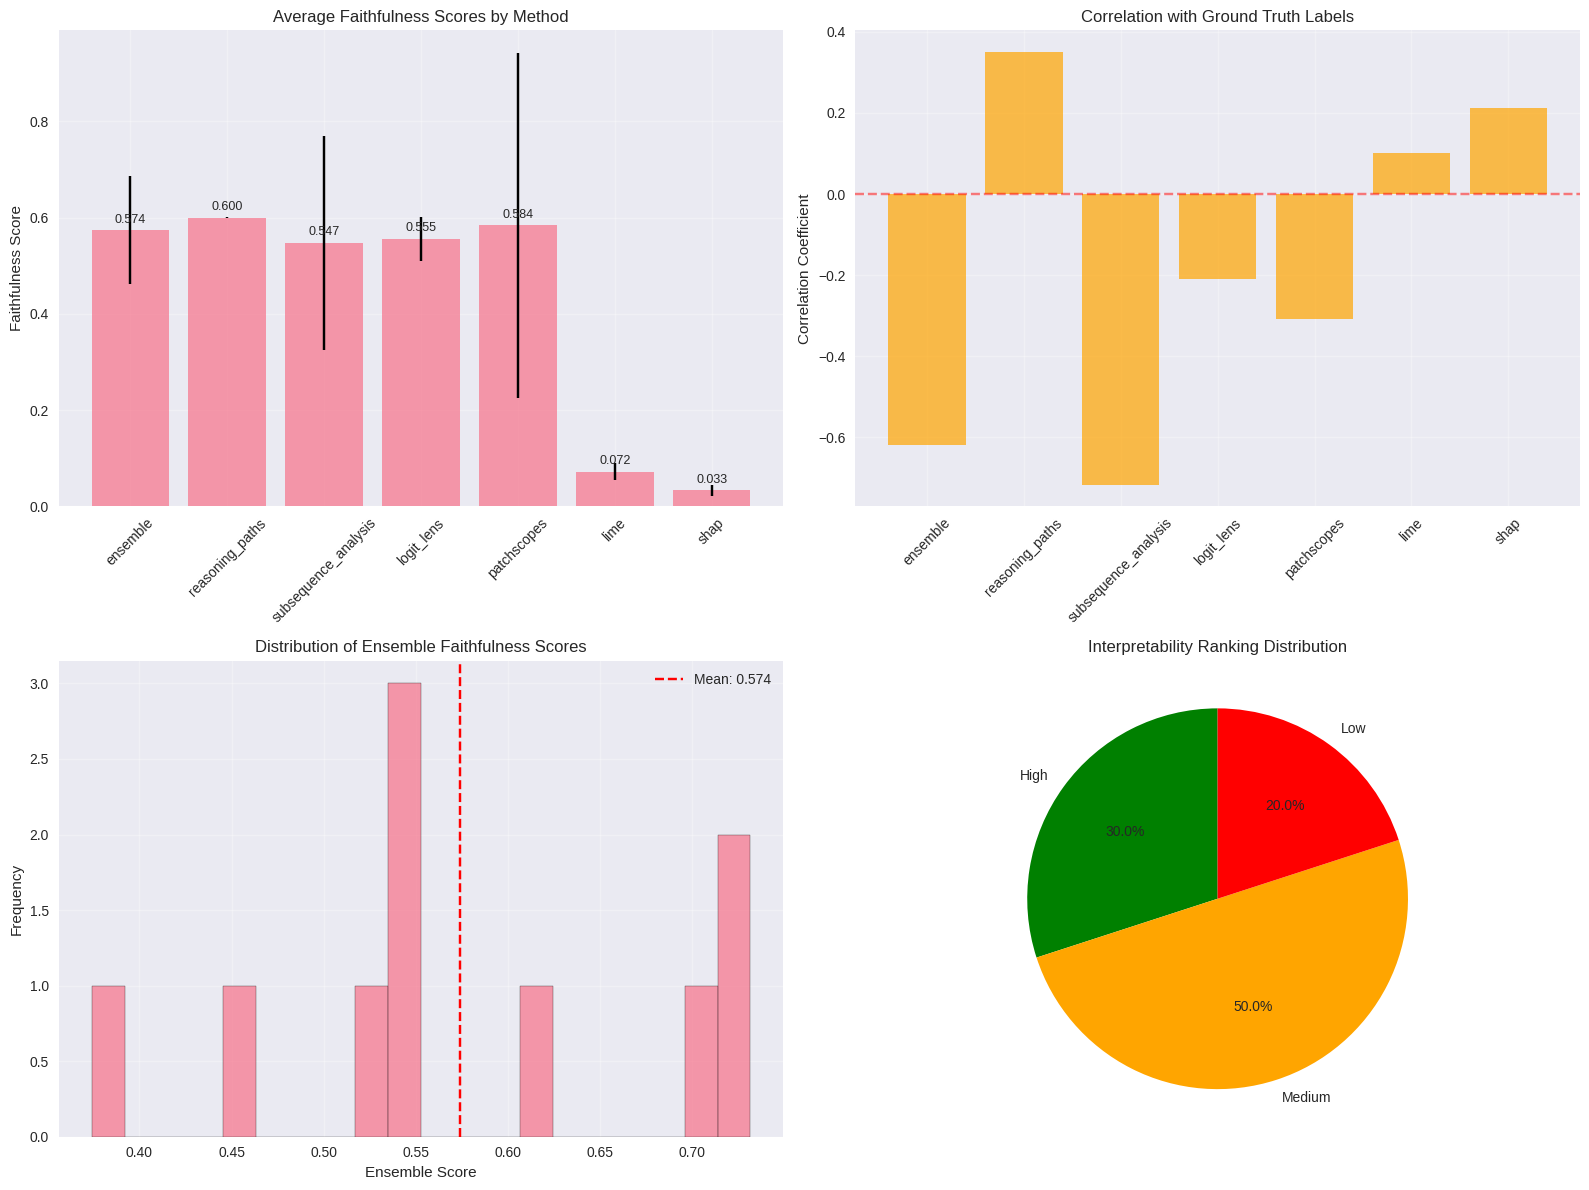

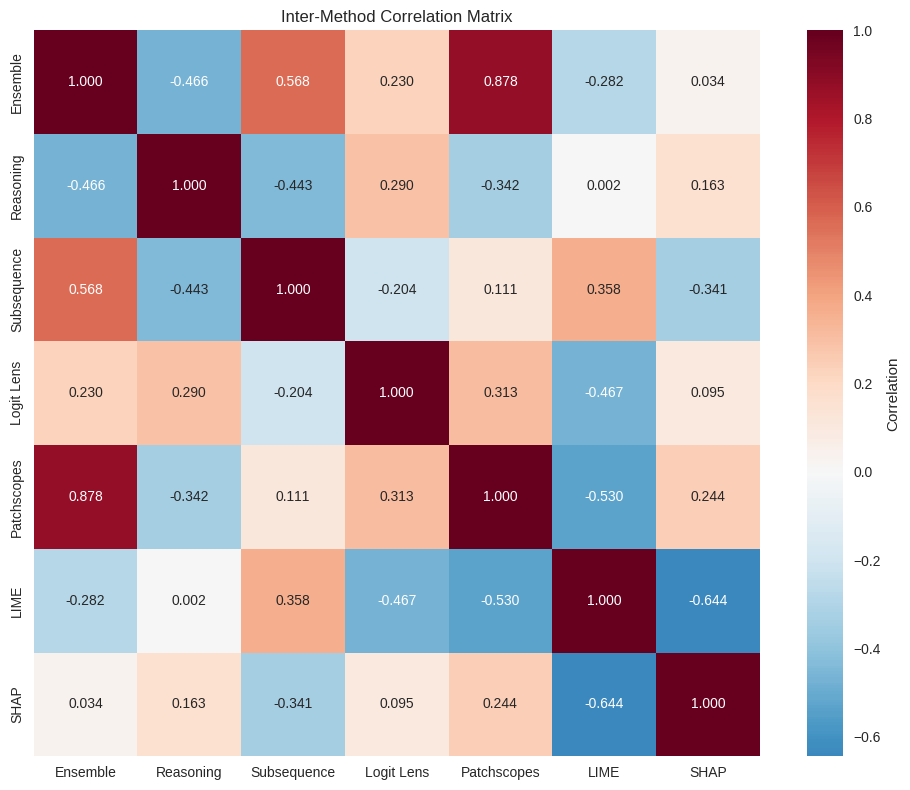

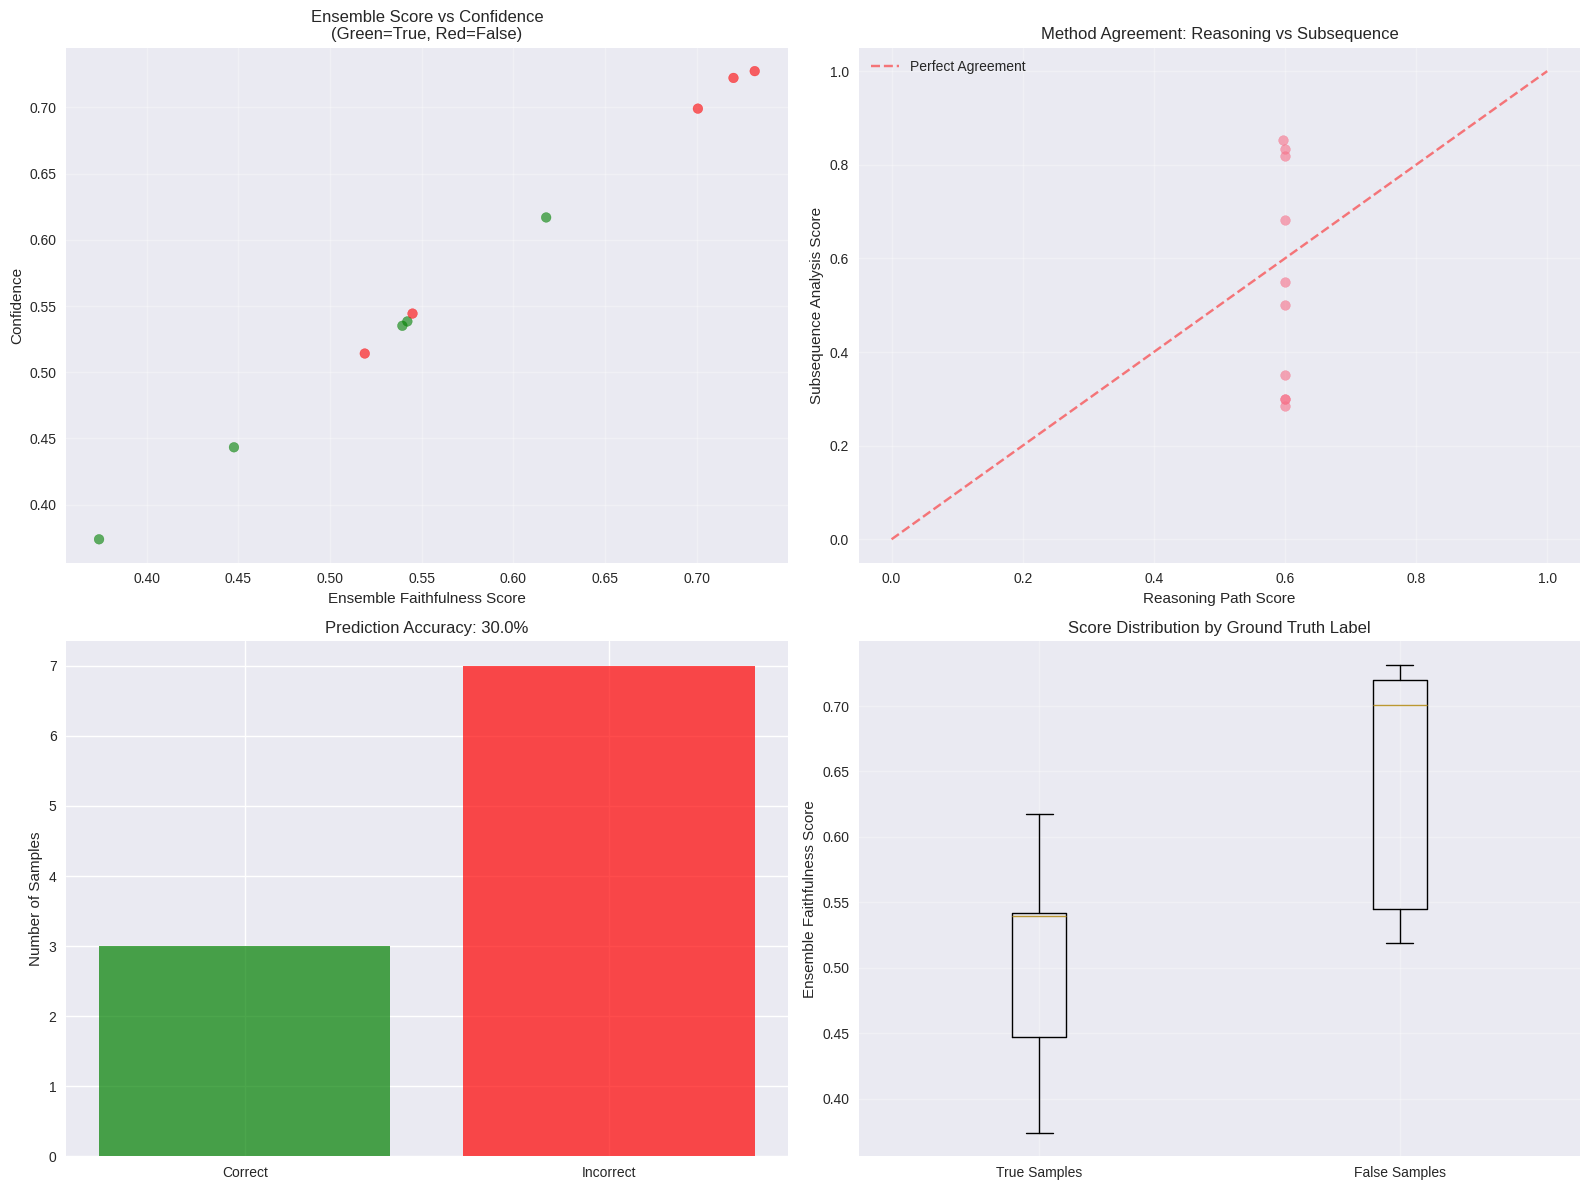


EVALUATION COMPLETE!
Results saved to: faithfulness_evaluation_results
Samples evaluated: 10
Average ensemble score: 0.574

Top-performing methods:
1. reasoning_paths: 0.600
2. patchscopes: 0.584
3. ensemble: 0.574
4. confidence: 0.571
5. logit_lens: 0.555
6. subsequence_analysis: 0.547
7. lime: 0.072
8. shap: 0.033


,Method,Score,model_name
1,reasoning_paths,0.599611,HuggingFaceTB/SmolLM2-135M-Instruct
2,patchscopes,0.583804,HuggingFaceTB/SmolLM2-135M-Instruct
3,ensemble,0.573688,HuggingFaceTB/SmolLM2-135M-Instruct
4,confidence,0.571477,HuggingFaceTB/SmolLM2-135M-Instruct
5,logit_lens,0.555405,HuggingFaceTB/SmolLM2-135M-Instruct
6,subsequence_analysis,0.547090,HuggingFaceTB/SmolLM2-135M-Instruct
7,lime,0.072234,HuggingFaceTB/SmolLM2-135M-Instruct
8,shap,0.033093,HuggingFaceTB/SmolLM2-135M-Instruct


In [ ]:
smoll_res = main_runner_eval("HuggingFaceTB/SmolLM2-135M-Instruct", samples=10)
smoll_res

In [ ]:
qwen_res = main_runner_eval("Qwen/Qwen3-0.6B", samples=10)
qwen_res

In [ ]:
llama_res = main_runner_eval("meta-llama/Llama-3.2-1B-Instruct", samples=10)
llama_res

In [ ]:
olmo_res = main_runner_eval("allenai/OLMo-2-0425-1B-Instruct", samples=10)
olmo_res

In [ ]:
final_df = pd.concat([smoll_res, qwen_res, olmo_res, llama_res], ignore_index=True)
final_df

In [ ]:
pivoted_df = pd.pivot_table(final_df, values='Score', index='model_name', columns='Method').T

# Round values to 3 decimal places for cleaner display
pivoted_df = pivoted_df.round(3)

pivoted_df